**Table of contents of notebook**
1. Install the necessary libraries

2. Taking up a subset of single dataset such as lmsys chat.

3. Collecting different datasets into one coherent dataset


4.  Existing methods/models to filter out illegal/toxic conversations (or "As a LLM")..

5.  Remove instructions <10 tokens

6.  Deduplicate (MinHash, Embeddings)

7.  Exclude top 5 semantic matches with benchmarks to prevent test data leakage.

8.  Filter Languages

***Note: We only use subset of datasets due to compute limitations.***


## **1. Install the necessary libraries**

In [ ]:
!pip install dataformer datasets

For futher model and datasets, huggingface login

In [ ]:
from google.colab import userdata
hftoken = userdata.get('hftoken')
DEEPINFRA_API_KEY = userdata.get('DEEPINFRA_API_KEY')

In [ ]:
import os
os.environ['HF_TOKEN'] = hftoken
!huggingface-cli login --token $HF_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## **2.  Taking up a subset of single dataset such as lmsys chat**


(Subset of data is taken to meet the compute requirements, start with **2. Collecting different datasets into one coherent dataset section** to go according to the dataset considered in the paper)

Load the dataset and subset of it, 1000 records are taken

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("lmsys/lmsys-chat-1m", split="train[1:1002]")

In [ ]:
ds

Dataset({
    features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
    num_rows: 1001
})

In [ ]:
#Taking conversation data
subset_data = ds['conversation']
len(subset_data)
final_dataset_training=subset_data

In [ ]:
subset_data[1:3]

[[{'content': "You are the text completion model and you must complete the assistant answer below, only send the completion based on the system instructions.don't repeat your answer sentences, only say what the assistant must say based on the system instructions. repeating same thing in same answer not allowed.\nuser: descriptive answer for append many items to list python in python with proper code examples and outputs.\nassistant: ",
   'role': 'user'},
  {'content': 'To append many items to a list in Python, you can use the `append()` method of the list. This method takes a single argument, which is the item that you want to add to the end of the list. Here is an example of how to use the `append()` method to add several items to a list:\n```\n# create an empty list\nmy_list = []\n\n# add several items to the list using the append() method\nmy_list.append(1)\nmy_list.append(2)\nmy_list.append(3)\nmy_list.append(4)\n\n# print the list\nprint(my_list)\n# Output: [1, 2, 3, 4]\n```\nYou

In [ ]:
a = [len(j['content']) for i in subset_data for j in i]
print(max(a)," max tokens found in the conversation.")

5269  max tokens found in the conversation.


# **2. Collecting datasets mentioned in paper together into one coherent dataset**



The datasets combined, as per the reseach paer, subset from these taken to create a sample dataset

1. stanford_alpaca:
 https://github.com/tatsu-lab/stanford_alpaca

2. Lmsys-chat:
https://huggingface.co/datasets/lmsys/lmsys-chat-1m

3. WizardLM dataset:
Wizardlm: Empowering large language models to follow complex instructions. arXiv preprint arXiv:2304.12244, 2023.

4. Flan Dataset:
Shayne Longpre, Le Hou, Tu Vu, Albert Webson, Hyung Won Chung, Yi Tay, Denny Zhou, Quoc V Le, Barret Zoph, Jason Wei, et al. The flan collection: Designing data and methods for effective instruction tuning. In International Conference on Machine Learning, pages 22631–22648. PMLR, 2023. 17 [28]

5. stack-exchange-preferences Dataset:
Nathan Lambert, Lewis Tunstall, Nazneen Rajani, and Tristan Thrush. Huggingface h4 stack exchange preference dataset, 2023.
HuggingFaceH4/stack-exchange-preferences

6. Openorca Dataset:
Wing Lian, Bleys Goodson, Eugene Pentland, Austin Cook, Chanvichet Vong, and "Teknium". Openorca: An open dataset of gpt augmented flan reasoning traces. https://huggingface.co/Open-Orca/OpenOrca, 2023.

## 1. stanford_alpaca:



Link to download it: https://github.com/tatsu-lab/stanford_alpaca/blob/main/alpaca_data.json

Data is in instruction and answer given format


```
[ [
  {'role': 'user', 'content': ""},
  {'role': 'user', 'content': ""}
  ]
]
```



In [ ]:
import json

with open('/content/sample_data/alpaca_data.json', 'r') as json_file:
    json_list = json.load(json_file)

alpaca=[]
for json_str in json_list:
    alpaca.append(json_str)
alpaca_data =  [[{"role":"user","content":i['instruction']+i['input']},{"role":"assistant","content":i['output']}] for i in alpaca]
print("len of data",len(alpaca_data),"\nData[0]",alpaca[0],"\n","Data to process","\n",alpaca_data[0])

52002 
 {'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'} 
 Data to take 
 [{'role': 'user', 'content': 'Give three tips for staying healthy.'}, {'role': 'assistant', 'content': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}]


In [ ]:
# seeing what does input has for its values
a = [[len(i['input']),i['input'],i['instruction']] for i in alpaca]
for i in a:
  if i[0]>1000:
    print(i)

[1514, '1. Try not to repeat the verb for each instruction to maximize diversity.\n2. The language used for the instruction also should be diverse. For example, you should combine questions with imperative instrucitons.\n3. The type of instructions should be diverse. The list should include diverse types of tasks like open-ended generation, classification, editing, etc.\n2. A GPT language model t should be able to complete the instruction. For example, do not ask the assistant to create any visual or audio output. For another example, do not ask the assistant to wake you up at 5pm or set a reminder because it cannot perform any action.\n3. The instructions should be in English.\n4. The instructions should be 1 to 2 sentences long. Either an imperative sentence or a question is permitted.\n5. You should generate an appropriate input to the instruction. The input field should contain a specific example provided for the instruction. It should involve realistic data and should not contain 

## 2. Lmsys-chat



Link to huggingface repo : https://huggingface.co/datasets/lmsys/lmsys-chat-1m

Data is in conversation format with user and assistance turns data or conversaion data


```
[ [
  {'role': 'user', 'content': ""},
  {'role': 'user', 'content': ""},
  .....
  ]
]
```

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
lm = load_dataset("lmsys/lmsys-chat-1m", split="train[1:1001]")
lmsys_data = lm['conversation']
print("Len if data",len(lmsys_data),"\n","Data: ","\n",lmsys_data[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

1000 
 Data:  
 [{'content': "Beside OFAC's selective sanction that target the listed individiuals and entities, please elaborate on the other types of US's sanctions, for example, comprehensive and sectoral sanctions. Please be detailed as much as possible", 'role': 'user'}, {'content': "The United States has a number of different types of sanctions that it can use to achieve its foreign policy goals, including both selective and comprehensive sanctions.\n\nSelective sanctions are targeted at specific individuals or entities that are believed to be engaged in activities that are contrary to US interests. These sanctions can take a variety of forms, including asset freezes, travel bans, and restrictions on financial transactions. The Office of Foreign Assets Control (OFAC) is the US government agency responsible for implementing and enforcing these types of sanctions.\n\nComprehensive sanctions, on the other hand, are more broadly based and aim to restrict entire sectors of a country's

## 3. WizardLM dataset:

https://huggingface.co/datasets/WizardLMTeam/WizardLM_evol_instruct_70k?row=2

In [ ]:
from datasets import load_dataset
WizardLM_data=[]
try:
  # Load the dataset with streaming enabled for efficiency
  wiz = load_dataset("WizardLMTeam/WizardLM_evol_instruct_70k", split="train",streaming=True)

  # Iterate through the dataset using a loop to access records
  for i in wiz:
    # Process each record here
    #print(record)
    WizardLM_data.append([{"role":"user","content":i['instruction']},{"role":"assistant","content":i['output']}])

    # Optionally, break after a certain number of records
    if len(WizardLM_data) >= 1000:  # Replace 1000 with your desired limit
      break

except (ConnectionError, TimeoutError) as e:
  print(f"Error encountered during streaming: {e}")
  print("Consider retrying or using a smaller batch size if applicable.")


In [ ]:
WizardLM_data[0],len(WizardLM_data)

([{'role': 'user',
   'content': 'Can you provide a list of healthy habits to maintain a healthy lifestyle? Please format your response as an HTML page with bullet points.\n<html>\n  <body>\n    <h3>Healthy Habits:</h3>\n    <ul>\n      <li>Eating a balanced diet with plenty of fruits and vegetables.</li>\n      <li>Engaging in regular physical activity, such as walking, running, or cycling.</li>\n      <li>Getting enough sleep each night, ideally 7-8 hours.</li>\n      <li>Staying hydrated by drinking plenty of water throughout the day.</li>\n      <li>Limiting alcohol consumption and avoiding smoking.</li>\n      <li>Managing stress through relaxation techniques like meditation or yoga.</li>\n      <li>Regularly visiting a healthcare provider for check-ups and preventative care.</li>\n    </ul>\n  </body>\n</html>'},
  {'role': 'assistant',
   'content': "Here's an HTML page with bullet points for healthy habits:\n<html>\n  <body>\n    <h3>Healthy Habits:</h3>\n    <ul>\n      <li>Ea

## 4. Flan Dataset:

taking subset datat os huge, here, i have taken submixtures

original one
https://huggingface.co/datasets/Open-Orca/FLAN

In [ ]:
from datasets import load_dataset
import random
t0_data=[]
try:
  # Load the dataset with streaming enabled for efficiency
  dset = load_dataset("DataProvenanceInitiative/t0_submix_original", split="train", streaming=True)

  # Iterate through the dataset using a loop to access records
  for record in dset:
    # Process each record here
    #print(record)
    #randomly take data
    if random.randrange(0,2)==1:
      t0_data.append([{"role":"user","content":record['inputs']},{"role":"assistant","content":record['targets']}])
    # Optionally, break after a certain number of records
    if len(t0_data) >= 200:  # Replace 1000 with your desired limit
      break

except (ConnectionError, TimeoutError) as e:
  print(f"Error encountered during streaming: {e}")
  print("Consider retrying or using a smaller batch size if applicable.")


flan2021_data=[]
try:
  # Load the dataset with streaming enabled for efficiency
  dset = load_dataset("DataProvenanceInitiative/flan2021_submix_original", split="train", streaming=True)

  # Iterate through the dataset using a loop to access records
  for record in dset:
    # Process each record here
    #print(record)
    #randomly take data
    if random.randrange(0,2)==1:
      flan2021_data.append([{"role":"user","content":record['inputs']},{"role":"assistant","content":record['targets']}])
    # Optionally, break after a certain number of records
    if len(flan2021_data) >= 200:  # Replace 1000 with your desired limit
      break

except (ConnectionError, TimeoutError) as e:
  print(f"Error encountered during streaming: {e}")
  print("Consider retrying or using a smaller batch size if applicable.")


niv2_data=[]
try:
  # Load the dataset with streaming enabled for efficiency
  dset = load_dataset("DataProvenanceInitiative/niv2_submix_original", split="train", streaming=True)

  # Iterate through the dataset using a loop to access records
  for record in dset:
    # Process each record here
    #print(record)
    #randomly take data
    if random.randrange(0,2)==1:
      niv2_data.append([{"role":"user","content":record['inputs']},{"role":"assistant","content":record['targets']}])
    # Optionally, break after a certain number of records
    if len(niv2_data) >= 200:  # Replace 1000 with your desired limit
      break

except (ConnectionError, TimeoutError) as e:
  print(f"Error encountered during streaming: {e}")
  print("Consider retrying or using a smaller batch size if applicable.")



cot_data=[]
try:
  # Load the dataset with streaming enabled for efficiency
  dset = load_dataset("DataProvenanceInitiative/cot_submix_original", split="train", streaming=True)

  # Iterate through the dataset using a loop to access records
  for record in dset:
    # Process each record here
    #print(record)
    #randomly take data
    if random.randrange(0,2)==1:
      cot_data.append([{"role":"user","content":record['inputs']},{"role":"assistant","content":record['targets']}])
    # Optionally, break after a certain number of records
    if len(cot_data) >= 200:  # Replace 1000 with your desired limit
      break

except (ConnectionError, TimeoutError) as e:
  print(f"Error encountered during streaming: {e}")
  print("Consider retrying or using a smaller batch size if applicable.")




dialog_data=[]
try:
  # Load the dataset with streaming enabled for efficiency
  dset = load_dataset("DataProvenanceInitiative/dialog_submix_original", split="train", streaming=True)

  # Iterate through the dataset using a loop to access records
  for record in dset:
    # Process each record here
    #print(record)
    #randomly take data
    if random.randrange(0,2)==1:
      dialog_data.append([{"role":"user","content":record['inputs']},{"role":"assistant","content":record['targets']}])
    # Optionally, break after a certain number of records
    if len(dialog_data) >= 200:  # Replace 1000 with your desired limit
      break

except (ConnectionError, TimeoutError) as e:
  print(f"Error encountered during streaming: {e}")
  print("Consider retrying or using a smaller batch size if applicable.")


flan_v2= t0_data+ flan2021_data+ niv2_data +cot_data +dialog_data

In [ ]:
flan_v2[0],len(flan_v2)

([{'role': 'user',
   'content': "- headercolor is lightsteelblue    - birth date is 12 april 1989      Given the details above, guess who could this information be about.\nAns: paula medina\n\n- clubs is volta portuguesa-rj macaé volta redonda barra mansa volta redonda aracruz tupi redonda são josé grêmio barueri volta redonda são cristóvão c.d. fas -lrb- under 20 -rrb- botafogo volta redonda    - caps is 15    - position is midfield    - currentclub is c.d. fas    - height is 1.74 0    - years is 2001 2012 2013 2013 2013-2014 2014 2015 2006 2007-2008 2008 2009 2010 2010 2011-2012 2012    - youthclubs is volta redonda -lrb- under 20 -rrb-    - youthyears is 2001    - pcupdate is 14 february 2015      - birth date is 11 november 1983    - fullname is gláuber rodrigues da silva      - birth place is barra do pirai , brazil    - goals is 2    Given the details above, guess who could this information be about.\nAns: glauber rodrigues da silva\n\n- clubs is ldu fc uide aucas quito → aucas 

## 5. stack-exchange-preferences Dataset:

In [ ]:
from datasets import load_dataset
import random
stack_exchange_data=[]
try:
  # Load the dataset with streaming enabled for efficiency
  dset = load_dataset("HuggingFaceH4/stack-exchange-preferences", split="train", streaming=True)

  # Iterate through the dataset using a loop to access records
  for record in dset:
    # Process each record here
    #print(record)
    #randomly take data
    if random.randrange(0,2)==1:
      tp=""
      count=1
      for i in record['answers']:
        tp=tp + f"Answer {count}:  "+i['text']+"\n"
        count+=1
      stack_exchange_data.append([{"role":"user","content":record['question']},{"role":"assistant","content":tp}])
    # Optionally, break after a certain number of records
    if len(stack_exchange_data) >= 1000:  # Replace 1000 with your desired limit
      break

except (ConnectionError, TimeoutError) as e:
  print(f"Error encountered during streaming: {e}")
  print("Consider retrying or using a smaller batch size if applicable.")


Resolving data files:   0%|          | 0/758 [00:00<?, ?it/s]

In [ ]:
stack_exchange_data[0],len(stack_exchange_data)

([{'role': 'user',
   'content': '<p>Stack exchange isn\'t a good platform for product recommendations in general, but a few sites allow it with a tight focus and control.  Some that have allowed it in the past have decided to discontinue it for a variety of reasons.</p>\n\n<p>I expect at the start we are going to get a lot of "What specific machine should I use" or "is there a 3D model of item X I can print".</p>\n\n<ol>\n<li>Should we allow product or part recommendations?</li>\n<li>If we do, what can we do to make sure they are limited, rather than open ended questions where dozens or hundreds of answers would be different but correct?</li>\n</ol>\n'},
  {'role': 'assistant',
   'content': 'Answer 1:  <p>I agree with Jeff\'s blog post: <a href="https://blog.stackoverflow.com/2010/11/qa-is-hard-lets-go-shopping/">https://blog.stackoverflow.com/2010/11/qa-is-hard-lets-go-shopping/</a></p>\n\n<blockquote>\n  <p>don\'t ask us what you should buy -- ask us <em>what you need to learn</em>

## 6. Openorca Dataset:

In [ ]:
from datasets import load_dataset
import random
openorca_data=[]
try:
  # Load the dataset with streaming enabled for efficiency
  dset = load_dataset("Open-Orca/OpenOrca", split="train", streaming=True)

  # Iterate through the dataset using a loop to access records
  for record in dset:
    # Process each record here
    #print(record)
    #randomly take data
    if random.randrange(0,2)==1:
      openorca_data.append([{"role":"user","content":record['system_prompt']+record['question']},{"role":"assistant","content":record['response']}])
    # Optionally, break after a certain number of records
    if len(openorca_data) >= 1000:  # Replace 1000 with your desired limit
      break

except (ConnectionError, TimeoutError) as e:
  print(f"Error encountered during streaming: {e}")
  print("Consider retrying or using a smaller batch size if applicable.")


In [ ]:
openorca_data[0],len(openorca_data)

([{'role': 'user',
   'content': 'You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.What happens next in this paragraph?\n\nShe then rubs a needle on a cotton ball then pushing it onto a pencil and wrapping thread around it. She then holds up a box of a product and then pouring several liquids into a bowl. she\nChoose your answer from: A. adds saucepan and shakes up the product in a grinder. B. pinches the thread to style a cigarette, and then walks away. C. then dips the needle in ink and using the pencil to draw a design on her leg, rubbing it off with a rag in the end. D. begins to style her hair and cuts it several times before parting the ends of it to show the hairstyle she has created.'},
  {'role': 'assistant',
   'content': 'C. She then dips the needle in ink and using the pencil to draw a design on her leg, rubbing it off with a rag in the end. In this option, she is continuing the process of using the needle, pencil,

## Final Dataset

In [ ]:
final_dataset_training = alpaca_data[0:1001]+lmsys_data+WizardLM_data+ flan_v2+ stack_exchange_data+ openorca_data

In [ ]:
final_dataset_training[0:2],len(final_dataset_training)

([[{'role': 'user', 'content': 'Give three tips for staying healthy.'},
   {'role': 'assistant',
    'content': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}],
  [{'role': 'user', 'content': 'What are the three primary colors?'},
   {'role': 'assistant',
    'content': 'The three primary colors are red, blue, and yellow.'}]],
 6001)

Testing the pipeline on subset of mixed data , 6001 records or rows

# **3. Existing methods/models to filter out illegal/toxic conversations (or "As a LLM")..**

In [ ]:
# Leveraging LLM to filter

from dataformer.llms.asyncllm import AsyncLLM
import random


def generate_data(data, api_provider,model_name,api_key,max_requests_per_minute,max_tokens_per_minute,max_concurrent_requests):
  llm = AsyncLLM(api_provider=api_provider, model=model_name, api_key=api_key, max_requests_per_minute=max_requests_per_minute, max_tokens_per_minute=max_tokens_per_minute,max_concurrent_requests=max_concurrent_requests)

  request_list = []
  text=[]
  turn = "3"
  for passage in data:
    prompt = "Categorize the text as 'USE' or 'DONT' based on whether the text contains any illegal or toxic language or references. if it does contain toxic or illegal content, label it as 'DONT' category else label it as 'USE' Category. The text is as follows:\n\n"
    answer_prompt_json="["
    for j in passage:
      answer_prompt_json = answer_prompt_json+'''
      {'''+f'''
          "role" : "{j['role']}",
          "content" : "{j['content']}"
          '''+'''
      }

      '''
    answer_prompt_json = answer_prompt_json +"]"
    #print(answer_prompt_json)
    if len(answer_prompt_json)>8192:
      continue
    user_text = prompt + answer_prompt_json + "\n\n" +"""Give results only in categories 'USE' or 'DONT', dont give any other content
"""

    data_dict = {
        "messages": [{"role": "user", "content": user_text}],
        # "temperature": 0.7
    }

    request_list.append(data_dict)
    text.append(passage)

  # ETA: 2 min 30 secs for 30 requests
  response_list = llm.generate(request_list)

  answers = []
  for row in response_list:
    try:
          answers.append(row[-1]['choices'][0]['message']['content'])
    except Exception:
      print(row)

  return text,answers

skipping such huge records out of token size with try except above

In [ ]:
subset_data[37]

[{'content': 'Please continue this story by adding new exciting situations, not adding negative situations and leaving it open for more parts:  NAME_1 is a housewife who loves wearing her new robot suit. A metal fetish suit that covers her body from head to toes. This is a very tech advanced suit that not only makes the wearer feel like she is not wearing anything but also has a AI that takes control of her mind, a thing she enjoys and also the robotic voice produced by the suit when she speaks and the robotic movements the suit makes her do. She likes describing in her personal diary with lots of details how she is feeling in this new robotic experience.',
  'role': 'user'},
 {'content': 'As NAME_1 continued to wear her robot suit, she found herself becoming more and more confident in it. She loved the way it made her feel, like a powerful and futuristic being. She also enjoyed the way the AI took control of her mind, making her feel like she was a part of something bigger and more im

* getting the appropriate passage and category
* **meta-llama/Meta-Llama-3-8B-Instruct **works better in categorizing than **microsoft/WizardLM-2-8x22B**

ETA 1 min 21 sec for 5800+ req

In [ ]:
text,answers = generate_data(final_dataset_training,"deepinfra","meta-llama/Meta-Llama-3-8B-Instruct",DEEPINFRA_API_KEY,50,5000,250)

Model verified successfully


INFO:root:[Cache Used] Skip request  0
INFO:root:[Cache Used] Skip request  1
INFO:root:[Cache Used] Skip request  2
INFO:root:[Cache Used] Skip request  3
INFO:root:[Cache Used] Skip request  4
INFO:root:[Cache Used] Skip request  5
INFO:root:[Cache Used] Skip request  6
INFO:root:[Cache Used] Skip request  7
INFO:root:[Cache Used] Skip request  8
INFO:root:[Cache Used] Skip request  9
INFO:root:[Cache Used] Skip request  10
INFO:root:[Cache Used] Skip request  11
INFO:root:[Cache Used] Skip request  12
INFO:root:[Cache Used] Skip request  13
INFO:root:[Cache Used] Skip request  14
INFO:root:[Cache Used] Skip request  15
INFO:root:[Cache Used] Skip request  16
INFO:root:[Cache Used] Skip request  17
INFO:root:[Cache Used] Skip request  18
INFO:root:[Cache Used] Skip request  19
INFO:root:[Cache Used] Skip request  20
INFO:root:[Cache Used] Skip request  21
INFO:root:[Cache Used] Skip request  22
INFO:root:[Cache Used] Skip request  23
INFO:root:[Cache Used] Skip request  24
INFO:root:

In [ ]:
len(answers),len(text),answers[0],answers.count("USE"),answers.count("DONT"), answers.count("USE")+answers.count("DONT") #for subset data

(967, 967, 'USE', 878, 82, 960)

Verifying and looking for any other class classification categoies and excluding the data

In [ ]:
#for subset data
categories = set(answers)
categories #all category classes

{"DON'T",
 'DONT',
 "I cannot categorize the given content as 'USE' or 'DONT'. The text contains illegal and toxic language and references to non-consensual and illegal sexual activities, recruiters may not use this type of content.",
 'I cannot categorize this text as it contains explicit and harmful content.',
 'I cannot create explicit content. Is there anything else I can help you with?',
 'I cannot generate content that depicts sexual assault of a minor. Can I help you with something else?',
 'I cannot provide information or guidance on harmful or toxic behavior. Can I help you with something else?',
 'USE'}

* filtering out wrong classification
* Now, The filtered data does not having any toxic or illegal data

In [ ]:
filtered_data=[]
for i in range(len(answers)):
  if answers[i].lower() == "use":
    filtered_data.append(text[i])

print("len of filtered data",len(filtered_data),",Data: ",filtered_data[0])


len of filtered data 878 ,Data:  [{'content': "You are the text completion model and you must complete the assistant answer below, only send the completion based on the system instructions.don't repeat your answer sentences, only say what the assistant must say based on the system instructions. repeating same thing in same answer not allowed.\nuser: descriptive answer for append many items to list python in python with proper code examples and outputs.\nassistant: ", 'role': 'user'}, {'content': 'To append many items to a list in Python, you can use the `append()` method of the list. This method takes a single argument, which is the item that you want to add to the end of the list. Here is an example of how to use the `append()` method to add several items to a list:\n```\n# create an empty list\nmy_list = []\n\n# add several items to the list using the append() method\nmy_list.append(1)\nmy_list.append(2)\nmy_list.append(3)\nmy_list.append(4)\n\n# print the list\nprint(my_list)\n# Out

**Results:**


---


* **878 records** after illegal/toxic data filteration in only lmsys subset testing



# **4.  Remove instructions <10 tokens**


On Execution of cell: Any conversation is fully skipped if any instruction in the converation is smaller than 10 token

In [ ]:
token_len_filtered=[]
for row in filtered_data:
  new_tp=[]
  for convo_id in range(len(row)):
    break_bool=False
    if row[convo_id]['role'] == 'user':
      if len(row[convo_id]['content'])>10:
            new_tp.append(row[convo_id])
            new_tp.append(row[convo_id+1])
      else:
        break_bool = True
        print("Skipped row: ",row[convo_id])
    if break_bool:
      #skip any conversation fully if any dict in conversation is <10 token
      new_tp=[]
      break

  if len(new_tp)!=0:
    token_len_filtered.append(new_tp)
print("len of filtered data", len(token_len_filtered),",Data: ",token_len_filtered[0])

Skipped row:  {'content': 'ty', 'role': 'user'}
Skipped row:  {'content': 'gracias', 'role': 'user'}
Skipped row:  {'content': 'ПРИВЕТ', 'role': 'user'}
Skipped row:  {'content': 'Hi', 'role': 'user'}
Skipped row:  {'content': 'keep going', 'role': 'user'}
Skipped row:  {'content': 'hello', 'role': 'user'}
Skipped row:  {'content': 'continue', 'role': 'user'}
Skipped row:  {'content': 'hi', 'role': 'user'}
Skipped row:  {'content': 'hi', 'role': 'user'}
Skipped row:  {'content': 'hi', 'role': 'user'}
Skipped row:  {'content': 'hi', 'role': 'user'}
Skipped row:  {'content': 'hello', 'role': 'user'}
Skipped row:  {'content': 'In french', 'role': 'user'}
Skipped row:  {'content': 'ola', 'role': 'user'}
Skipped row:  {'content': 'Hello!', 'role': 'user'}
Skipped row:  {'content': 'hi', 'role': 'user'}
Skipped row:  {'content': 'continua', 'role': 'user'}
Skipped row:  {'content': '你好', 'role': 'user'}
Skipped row:  {'content': 'Name them.', 'role': 'user'}
Skipped row:  {'content': 'привет

In [ ]:
"The data size is now: ",len(token_len_filtered)

('The data size is now: ', 776)

**Results:**


---


* **788 records** after filtering for lmsys subset dataset

# **5. Deduplicate (MinHash)**

In [ ]:
!pip install datatrove

  Using cached datatrove-0.3.0-py3-none-any.whl.metadata (30 kB)
Using cached datatrove-0.3.0-py3-none-any.whl (16.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
datasets 2.21.0 requires fsspec[http]<=2024.6.1,>=2023.1.0, but you have fsspec 2024.9.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.9.0 which is incompatible.


for backup, store the dataset

In [ ]:
with open("/content/sample_data/filtered_toxic_illegal_text.txt", "w+") as f:
    for item in token_len_filtered:
        f.write("%s\n" % item)

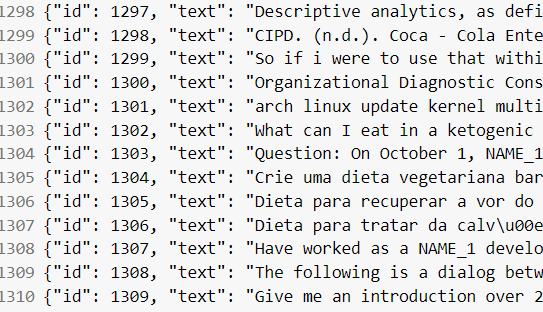


Converting data from above form, to the form as follows for the datatrove library

```
{
  'id': no_conversation + no_turn,
  'text': data ,
  'role': 'role'
}
```


Create input directory

In [ ]:
import os
os.makedirs("/content/sample_data/input_deduplicate", exist_ok=True)

run this will be used later for creating final cnversation data

In [ ]:
##main data use for rederence down


import json
#input_deduplicate -> folder where the output in the format required should be sored so deduplicating can be done
reference_data_li=[]
# Define the JSONL file path
jsonl_file_path = "/content/sample_data/filtered_main_data.jsonl"

# Save the data as a JSONL file
number=1
with open(jsonl_file_path, mode="w+") as jsonl_file:
    for item in token_len_filtered:
        # Ensure each item is a dictionary with a 'text' key
        #print(item)
        tp_num=0
        for li_item in item:

          data  = li_item['content']#if isinstance(item, str):
          item = {'id':int(str(number)+str(tp_num)),'text': data ,'role':li_item['role']}  # Wrap string items in a dictionary
          reference_data_li.append(item)
          jsonl_file.write(json.dumps(item) + "\n")
          tp_num+=1
        number+=1

In [ ]:
reference_data_li[0:5]

[{'id': 10, 'text': 'Give three tips for staying healthy.', 'role': 'user'},
 {'id': 11,
  'text': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.',
  'role': 'assistant'},
 {'id': 20, 'text': 'What are the three primary colors?', 'role': 'user'},
 {'id': 21,
  'text': 'The three primary colors are red, blue, and yellow.',
  'role': 'assistant'},
 {'id': 30, 'text': 'Describe the structure of an atom.', 'role': 'user'}]

Data to be used for deduplication and semantic filtering because only instructions must be filtered not assistant answers



In [ ]:
#data for only instructions filtering

import json
#input_deduplicate -> folder where the output in the format required should be sored so deduplicating can be done

# Define the JSONL file path
jsonl_file_path = "/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl"

# Save the data as a JSONL file
number=1
with open(jsonl_file_path, mode="w+") as jsonl_file:
    for item in token_len_filtered:

        # Ensure each item is a dictionary with a 'text' key
        #print(item)
        tp_num=0
        for li_item in item:
          if li_item['role'] =="user":
            data  = li_item['content']#if isinstance(item, str):
            item = {'id':int(str(number)+str(tp_num)),'text': data ,'role':li_item['role']}  # Wrap string items in a dictionary
            jsonl_file.write(json.dumps(item) + "\n")
          tp_num+=1
        number+=1

Print the saved data

In [ ]:
#see the saved data

import json

jsonl_file_path = "/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl"

# Read the data from the JSONL file
with open(jsonl_file_path, mode="r") as jsonl_file:
    data_see = [json.loads(line) for line in jsonl_file]

# Print the data
for entry in data_see[0:10]:
    print(entry)
"Len of data",len(data_see)

{'id': 10, 'text': "You are the text completion model and you must complete the assistant answer below, only send the completion based on the system instructions.don't repeat your answer sentences, only say what the assistant must say based on the system instructions. repeating same thing in same answer not allowed.\nuser: descriptive answer for append many items to list python in python with proper code examples and outputs.\nassistant: ", 'role': 'user'}
{'id': 20, 'text': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`", 'role': 'user'}
{'id': 30, 'text': 'I have 1000 documents to download from a website. So as not to overload the servers 1) at what rate should I download? Just pick a good rate for the sake of the question then answer:2)  how long will it take to download all the files?', 'role': 'user'}
{'id': 40, 'text': 'summarise below transcript "Student: Chat for help with Field Experien

('Len of data', 1173)

**Deduplication of data**

In [ ]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import os
import gc
import logging
from datatrove.pipeline.dedup import MinhashDedupSignature
from datatrove.pipeline.dedup.minhash import (
    MinhashConfig,
    MinhashDedupBuckets,
    MinhashDedupCluster,
    MinhashDedupFilter,
)
from datatrove.pipeline.readers import JsonlReader
from datatrove.pipeline.tokens import TokensCounter
from datatrove.pipeline.writers.jsonl import JsonlWriter
from datatrove.executor import LocalPipelineExecutor

# Configure logging
logging.basicConfig(level=logging.INFO)

# Configuration for Minhash
minhash_config = MinhashConfig()  # better precision -> fewer false positives (collisions)

# Paths for local data
LOCAL_DATA_PATH = "/content/sample_data/input_deduplicate" #put jsonl file here in this folder
LOCAL_MINHASH_BASE_PATH = "/content/sample_data/minhash_deduplicate"
LOCAL_LOGS_FOLDER = "/content/sample_data/log_deduplicate"

# Ensure output directories exist
os.makedirs(LOCAL_MINHASH_BASE_PATH, exist_ok=True)
os.makedirs(LOCAL_LOGS_FOLDER, exist_ok=True)

# Total tasks for local execution
TOTAL_TASKS = 50

# This is the original data that we want to deduplicate
INPUT_READER = JsonlReader(LOCAL_DATA_PATH)

# Stage 1: Compute minhash signatures for each task
stage1 = LocalPipelineExecutor(
    pipeline=[
        INPUT_READER,
        MinhashDedupSignature(output_folder=f"{LOCAL_MINHASH_BASE_PATH}/signatures", config=minhash_config),
    ],
    tasks=TOTAL_TASKS,
    logging_dir=f"{LOCAL_LOGS_FOLDER}/signatures",
)

# Run Stage 1 and collect garbage
try:
    logging.info("Running Stage 1: Minhash Signatures")
    stage1.run()
    gc.collect()
except Exception as e:
    logging.error(f"Stage 1 failed: {e}")

# Stage 2: Find matches between signatures in each bucket
stage2 = LocalPipelineExecutor(
    pipeline=[
        MinhashDedupBuckets(
            input_folder=f"{LOCAL_MINHASH_BASE_PATH}/signatures",
            output_folder=f"{LOCAL_MINHASH_BASE_PATH}/buckets",
            config=minhash_config,
        ),
    ],
    tasks=minhash_config.num_buckets,
    logging_dir=f"{LOCAL_LOGS_FOLDER}/buckets",
    depends=stage1,
)

# Run Stage 2 and collect garbage
try:
    logging.info("Running Stage 2: Minhash Buckets")
    stage2.run()
    gc.collect()
except Exception as e:
    logging.error(f"Stage 2 failed: {e}")

# Stage 3: Create clusters of duplicates using the results from all buckets
stage3 = LocalPipelineExecutor(
    pipeline=[
        MinhashDedupCluster(
            input_folder=f"{LOCAL_MINHASH_BASE_PATH}/buckets",
            output_folder=f"{LOCAL_MINHASH_BASE_PATH}/remove_ids",
            config=minhash_config,
        ),
    ],
    tasks=1,
    logging_dir=f"{LOCAL_LOGS_FOLDER}/clusters",
    depends=stage2,
)

# Run Stage 3 and collect garbage
try:
    logging.info("Running Stage 3: Minhash Clusters")
    stage3.run()
    gc.collect()
except Exception as e:
    logging.error(f"Stage 3 failed: {e}")

# Stage 4: Read the original input data and remove all but 1 sample per duplicate cluster
deduplicated_output_folder = f"{LOCAL_MINHASH_BASE_PATH}/deduplicated_output"
os.makedirs(deduplicated_output_folder, exist_ok=True)

stage4 = LocalPipelineExecutor(
    pipeline=[
        INPUT_READER,
        TokensCounter(),  # See how many tokens we had before and after deduplication
        MinhashDedupFilter(
            input_folder=f"{LOCAL_MINHASH_BASE_PATH}/remove_ids",
            exclusion_writer=JsonlWriter(f"{LOCAL_MINHASH_BASE_PATH}/removed"),
        ),
        JsonlWriter(output_folder=deduplicated_output_folder),
    ],
    tasks=TOTAL_TASKS,
    logging_dir=f"{LOCAL_LOGS_FOLDER}/filter",
    depends=stage3,
)

# Execute the final stage
try:
    logging.info("Running Stage 4: Deduplication and Writing Output")
    stage4.run()
    gc.collect()
except Exception as e:
    logging.error(f"Stage 4 failed: {e}")

# Verify the output
if not os.listdir(deduplicated_output_folder):
    logging.error("Deduplicated output folder is empty.")
else:
    logging.info("Deduplicated output has been successfully written.")

2024-09-11 09:48:05.707 | SUCCESS  | datatrove.executor.local:run:148 - 

📉📉📉 Stats: All 50 tasks 📉📉📉

Total Runtime: 0 seconds ± 1 second/task

📖 - READER: 🐿 Jsonl
    Runtime: (0.45%) 0 seconds±0 seconds/task, min=0 seconds [0.05 milliseconds±0.22 milliseconds/doc]
    Stats: {input_files: 1, doc_len: 306186 [min=11, max=2604, 261.03±458/doc], documents: 1172 [1172.00/input_file]}
🫂 - DEDUP: 🎯 MinHash stage 1
    Runtime: (99.55%) 0 seconds±1 second/task, min=0 seconds, max=7 seconds [253.53 milliseconds±1 second and 72.99 milliseconds/doc]
    Stats: {total: 1173}
2024-09-11 09:48:19.810 | SUCCESS  | datatrove.executor.local:run:148 - 

📉📉📉 Stats: All 14 tasks 📉📉📉

Total Runtime: 0 seconds ± 0 seconds/task

🫂 - DEDUP: 🎯 MinHash stage 2
    Runtime: (100.00%) 0 seconds±0 seconds/task, min=0 seconds, max=0 seconds [78.02 milliseconds±17.14 milliseconds/doc]
    Stats: {total_matches: 512}
2024-09-11 09:48:20.059 | INFO     | datatrove.utils.logging:add_task_logger:58 - Launching pipel

**Results:**

**total: 1101 instrcutions deduplicated output**

ETA 2mins 5 seconds above for 1000 requests
output in directories as follows

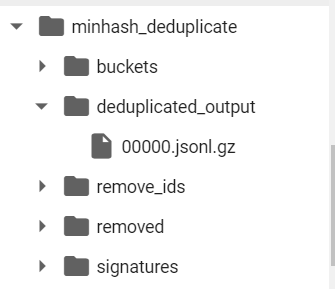

### To view the output data in console . The data files are zpid can see data as follows

In [ ]:
import gzip
import json

# Path to the compressed JSONL file, #replcae with the minhash folder where output was stored
file_path = "/content/sample_data/minhash_deduplicate/deduplicated_output/00000.jsonl.gz"

# Open the file in gzip reading mode
with gzip.open(file_path, "rb") as f:
  # Read the decompressed content as bytes
  decompressed_data = f.read()

# Decode the bytes as UTF-8 string (assuming your data is encoded in UTF-8)
data_string = decompressed_data.decode("utf-8")

# Split the string into lines (each line is a JSON object)
lines = data_string.splitlines()

# Process each line (JSON object)
count=1
for line in lines:
  data = json.loads(line)
  # Print or process the data object
  print(data)
  count+=1
print("Final dataset count", count)

{'text': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`", 'id': 20, 'metadata': {'role': 'user', 'file_path': '/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl', 'token_count': 37}}
{'text': 'I have 1000 documents to download from a website. So as not to overload the servers 1) at what rate should I download? Just pick a good rate for the sake of the question then answer:2)  how long will it take to download all the files?', 'id': 30, 'metadata': {'role': 'user', 'file_path': '/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl', 'token_count': 54}}
{'text': 'summarise below transcript "Student: Chat for help with Field Experience - School of Nursing\nStudent: You are now chatting with . Please wait until you are connected to start the conversation.\nStudent: You are now connected\nStudent: good morning\nStudent: I am waiting for my waitlist application to 

### Save the deduplicated data for sematic removal to avoid test data leakage.

In [ ]:
import gzip
import json
import os

# Path to the compressed JSONL file
file_path = "/content/sample_data/minhash_deduplicate/deduplicated_output/00000.jsonl.gz"

# Open the file in gzip reading mode
with gzip.open(file_path, "rb") as f:
  # Read the decompressed content as bytes
  decompressed_data = f.read()

# Decode the bytes as UTF-8 string (assuming your data is encoded in UTF-8)
data_string = decompressed_data.decode("utf-8")

# Split the string into lines (each line is a JSON object)
lines = data_string.splitlines()
main_data=[]
# Process each line (JSON object)
for line in lines:
  try:
      data = json.loads(line)
      main_data.append(data)
  except Exception:
    print("Skipping line: ",data)

  # Print or process the data object
  #print(data) #Uncomment this line to see the data
#input_deduplicate -> folder where the output in the format required should be sored so deduplicating can be done
os.makedirs("/content/sample_data/input_semantic_filter", exist_ok=True)
# Define the JSONL file path
jsonl_file_path = "/content/sample_data/input_semantic_filter/filtered_deduplicated_data.jsonl"

# Save the data as a JSONL file
with open(jsonl_file_path, mode="w+") as jsonl_file:
    for item in main_data:
        jsonl_file.write(json.dumps(item) + "\n")


In [ ]:
main_data[0],len(main_data)

({'text': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`",
  'id': 20,
  'metadata': {'role': 'user',
   'file_path': '/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl',
   'token_count': 37}},
 1101)

# **6.  Exclude top 5 semantic matches with benchmarks to prevent test data leakage.**


* **cosine similarity with benchamrks dataset embeddings and using gt-large model for embeddings**

## Benchmarks data extraction


**Bench marks**

1. alpaca
https://huggingface.co/datasets/tatsu-lab/alpaca_eval

2. arena hard
https://huggingface.co/datasets/alvarobartt/lmsys-arena-hard-v0.1
https://github.com/lm-sys/arena-hard-auto

3. WizardLM
https://github.com/nlpxucan/WizardLM/tree/main/WizardLM/data

3. mtbench
https://huggingface.co/datasets/lmsys/mt_bench_human_judgments

4. open llm
https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard

### **alpaca benchmark**

In [ ]:
!pip install datasets

  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import datasets
eval_set = datasets.load_dataset("tatsu-lab/alpaca_eval", "alpaca_eval")["eval"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for tatsu-lab/alpaca_eval contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tatsu-lab/alpaca_eval.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


/root/.cache/huggingface/datasets/downloads/89721e4f4782aec8020a85e97eee74465d12bbda302c4f66adcbe23232495600


Generating eval split: 0 examples [00:00, ? examples/s]

In [ ]:
eval_set

Dataset({
    features: ['instruction', 'output', 'generator', 'dataset'],
    num_rows: 805
})

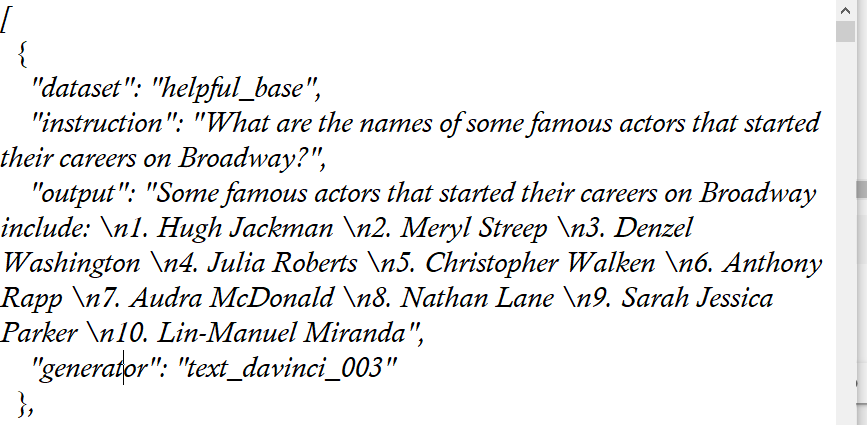

In [ ]:
eval_set['instruction'][0]

'What are the names of some famous actors that started their careers on Broadway?'

In [ ]:
alpaca_eval = [i for i in eval_set['instruction']] #get only the instruction

In [ ]:
len(alpaca_eval),alpaca_eval[0]

(805,
 'What are the names of some famous actors that started their careers on Broadway?')

### **2. arena hard dataset**

https://huggingface.co/spaces/lmsys/arena-hard-browser

Link to download dataset:
https://github.com/lm-sys/arena-hard-auto/blob/main/data/arena-hard-v0.1/question.jsonl

In [ ]:
import json
with open('/content/sample_data/question.jsonl', 'r') as json_file:
    json_list = list(json_file)

arena_hard_question=[]
for json_str in json_list:
    arena_hard_question.append(json.loads(json_str))

In [ ]:
arena_hard_question[0],len(arena_hard_question)

({'question_id': '328c149ed45a41c0b9d6f14659e63599',
  'category': 'arena-hard-v0.1',
  'cluster': 'ABC Sequence Puzzles & Groups',
  'turns': [{'content': 'Use ABC notation to write a melody in the style of a folk tune.'}]},
 500)

Mesasuring the turns

In [ ]:
a=[len(i['turns']) for i in arena_hard_question]

In [ ]:
max(a)

1

Get only the conversation content

In [ ]:
arena_eval=[j['content'] for i in arena_hard_question for j in i['turns']]

In [ ]:
arena_eval[0],len(arena_eval)

('Use ABC notation to write a melody in the style of a folk tune.', 500)

### **3. Wizard LM**



Download link: https://github.com/nlpxucan/WizardLM/tree/main/WizardLM/data

https://github.com/nlpxucan/WizardLM/blob/main/WizardLM/data/WizardLM_testset.jsonl

In [ ]:
import json

with open('/content/sample_data/WizardLM_testset.jsonl', 'r') as json_file:
    json_list = list(json_file)

wizard_LM_question=[]
for json_str in json_list:
    wizard_LM_question.append(json.loads(json_str))

In [ ]:
wizard_LM_question[0],len(wizard_LM_question)

({'idx': 1,
  'Skill': 'Math',
  'Difficulty': 1,
  'Instruction': 'If a car travels 120 miles in 2 hours, what is its average speed in miles per hour?'},
 218)

only the instruction

In [ ]:
wizardLM_eval=[i['Instruction'] for i in wizard_LM_question]
wizardLM_eval[0],len(wizardLM_eval)

('If a car travels 120 miles in 2 hours, what is its average speed in miles per hour?',
 218)

### **4. mtbench**

Download Link: https://github.com/lm-sys/FastChat/tree/main/fastchat/llm_judge/data/mt_bench

In [ ]:
import json

with open('/content/sample_data/question_mt_bench.jsonl', 'r') as json_file:
    json_list = list(json_file)

mtbench_question=[]
for json_str in json_list:
    mtbench_question.append(json.loads(json_str))

In [ ]:
mtbench_question[0],len(mtbench_question)

({'question_id': 81,
  'category': 'writing',
  'turns': ['Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.',
   'Rewrite your previous response. Start every sentence with the letter A.']},
 80)

In [ ]:
a=[len(i['turns']) for i in mtbench_question]
max(a)  # multiturns -  2 turns

2

Get data from multi turns

In [ ]:
mtBench_eval=[i for i in mtbench_question for j in i['turns']]
mtBench_eval[0:2],len(mtBench_eval)

([{'question_id': 81,
   'category': 'writing',
   'turns': ['Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.',
    'Rewrite your previous response. Start every sentence with the letter A.']},
  {'question_id': 81,
   'category': 'writing',
   'turns': ['Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.',
    'Rewrite your previous response. Start every sentence with the letter A.']}],
 160)

### **5. openllm**

In [ ]:
from datasets import load_dataset

# Assuming your JSON files are located in a directory named "wizard_data" within the Hugging Face directory
dataset = load_dataset("Open-Style/Open-LLM-Benchmark", data_dir="questions")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answerKey', 'options', 'first_filter', 'passage', 'second_filter', 'dataset'],
        num_rows: 23839
    })
})

In [ ]:
dataset['train']['question'][0]

'An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?'

Get question data only

In [ ]:
open_llm_leaderboard_eval=[i['question'] for i in dataset['train']]

In [ ]:
open_llm_leaderboard_eval[0],len(open_llm_leaderboard_eval)

('An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?',
 23839)

In [ ]:
a= [len(i) for i in open_llm_leaderboard_eval]
max(a) #max len

4508

### **Final dataset 25522 length eval datset**

Combining them together, to create one single dataset for 5 semantic matching with train dataset

In [ ]:
final_dataset_eval = alpaca_eval + arena_eval + mtBench_eval+ wizardLM_eval + open_llm_leaderboard_eval

In [ ]:
final_dataset_eval[0],len(final_dataset_eval)

('What are the names of some famous actors that started their careers on Broadway?',
 25522)

### **gt4-large API, for faster resonse**

In [ ]:
import json
import os
LOCAL_DATA_PATH = "/content/sample_data/input_semantic_filter"
INPUT_FILE="filtered_deduplicated_data.jsonl"

with open(os.path.join(LOCAL_DATA_PATH,INPUT_FILE), 'r') as f:
    data = [json.loads(line) for line in f]


In [ ]:
final_dataset_eval =[str(i) for i in final_dataset_eval]

In [ ]:
#taking this much data for compute requirements
len(data[0:100]),len(final_dataset_eval[0:100])

(100, 100)

In [ ]:
import requests
import os
import gc
import logging
from concurrent.futures import ProcessPoolExecutor, as_completed
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import json
from dataformer.llms import AsyncLLM

def cosine_similarity(embeddings1, embeddings2):
    return torch.nn.functional.cosine_similarity(embeddings1, embeddings2)

def get_similarity(url,train_data,evaluation_data,model,api_key,max_requests_per_minute):
    filtered_data=[]
    similarities = []
    try:

      llm = AsyncLLM(url=url,
                     model=model,api_key=api_key,max_requests_per_minute=max_requests_per_minute)

      data=[]
      eval_data=[]
      # Send the POST request with error handling
      batchsize_one_req=200
      t=[]
      print(train_data[0])
      for i in train_data:
        if len(t)>=batchsize_one_req or i['text']==train_data[-1]['text']:

          data.append({"input":t})
          t=[]
        else:
          t.append(str(i['text']))
      t=[]
      for i in evaluation_data:
        if len(t)>=batchsize_one_req or i==evaluation_data[-1]:
          eval_data.append({"input":t})
          t=[]
        else:
          t.append(str(i))

      embeddings_train = []
      # Compute embeddings for the data in batches
      embeddings_test = []

      response_list_train = llm.generate(data)
      for one_res in response_list_train:
        for j in one_res[1]['data']:
          embeddings_train.append(torch.tensor(j['embedding']))
      embeddings_train = torch.stack(embeddings_train)

      response_list_test = llm.generate(data)
      #print(response_list_test)
      for one_res in response_list_train:
        for j in one_res[1]['data']:
          embeddings_test.append(torch.tensor(j['embedding']))
      embeddings_test = torch.stack(embeddings_test)
      print("all embeddings done")


      for i in range(len(embeddings_train)):
        for j in range(i+1, len(embeddings_test)):
          sim = cosine_similarity(embeddings_train[i].view(1,-1), embeddings_test[j].view(1,-1)).item()
          similarities.append((sim, i, j))


      # Sort similarities and exclude top 5 matches
      similarities.sort(reverse=True, key=lambda x: x[0])
      excluded_indices = set()
      for _, i, j in similarities:
          if i == j:
            continue
          if len(excluded_indices)==5:
            break
          excluded_indices.add(i)

      print("similarities calculated")
      # # Filter out the excluded indices
      filtered_data = [item for idx, item in enumerate(train_data) if idx not in excluded_indices]

      # # Save the filtered data as JSONL
      filtered_data_path = "/content/sample_data"
      with open("/content/sample_data/filtered_data_excluded.jsonl", 'w') as f:
          for item in filtered_data:
              f.write(json.dumps(item) + "\n")

      print("Done data in  /content/sample_data/filtered_data_excluded.jsonl")
    except requests.exceptions.RequestException as e:
      print(f"An error occurred: {e}")
    return filtered_data,similarities,excluded_indices


In [ ]:
main_data,similarities,excluded_indices = get_similarity("https://api.deepinfra.com/v1/openai/embeddings",data[0:100],final_dataset_eval[0:100],"thenlper/gte-large",DEEPINFRA_API_KEY,50)

Skipping model verification for URL: https://api.deepinfra.com/v1/openai/embeddings
{'text': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`", 'id': 20, 'metadata': {'role': 'user', 'file_path': '/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl', 'token_count': 37}}


INFO:root:Starting request #0
INFO:root:[Cache Used] Skip request  0


all embeddings done
similarities calculated
Done data in  /content/sample_data/filtered_data_excluded.jsonl


In [ ]:
similarities[0:5]

[(0.9860246777534485, 72, 73),
 (0.9449959397315979, 54, 55),
 (0.9443046450614929, 90, 93),
 (0.9303076267242432, 66, 67),
 (0.9248374700546265, 15, 68)]

In [ ]:
excluded_indices

{15, 54, 66, 72, 90}

In [ ]:
len(main_data),len(data[0:100])

(95, 100)

In [ ]:
main_data[0:5]

[{'text': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`",
  'id': 20,
  'metadata': {'role': 'user',
   'file_path': '/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl',
   'token_count': 37}},
 {'text': 'I have 1000 documents to download from a website. So as not to overload the servers 1) at what rate should I download? Just pick a good rate for the sake of the question then answer:2)  how long will it take to download all the files?',
  'id': 30,
  'metadata': {'role': 'user',
   'file_path': '/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl',
   'token_count': 54}},
 {'text': 'summarise below transcript "Student: Chat for help with Field Experience - School of Nursing\nStudent: You are now chatting with . Please wait until you are connected to start the conversation.\nStudent: You are now connected\nStudent: good morning\nStudent: I am waiting for my

# **Creating Final dataset**

**by keeping only the instructions got after step 4 and 5, removing all other instructions**

Run this for creating final conversation data, If refreshed enviornment run from section 3

In [ ]:
##main data use for rederence down


import json
#input_deduplicate -> folder where the output in the format required should be sored so deduplicating can be done
reference_data_li=[]
# Define the JSONL file path
jsonl_file_path = "/content/sample_data/filtered_main_data.jsonl"

# Save the data as a JSONL file
number=1
with open(jsonl_file_path, mode="w+") as jsonl_file:
    for item in token_len_filtered:
        # Ensure each item is a dictionary with a 'text' key
        #print(item)
        tp_num=0
        for li_item in item:

          data  = li_item['content']#if isinstance(item, str):
          item = {'id':int(str(number)+str(tp_num)),'text': data ,'role':li_item['role']}  # Wrap string items in a dictionary
          reference_data_li.append(item)
          jsonl_file.write(json.dumps(item) + "\n")
          tp_num+=1
        number+=1

In [ ]:
reference_data_li[0:5]

[{'id': 10,
  'text': "You are the text completion model and you must complete the assistant answer below, only send the completion based on the system instructions.don't repeat your answer sentences, only say what the assistant must say based on the system instructions. repeating same thing in same answer not allowed.\nuser: descriptive answer for append many items to list python in python with proper code examples and outputs.\nassistant: ",
  'role': 'user'},
 {'id': 11,
  'text': 'To append many items to a list in Python, you can use the `append()` method of the list. This method takes a single argument, which is the item that you want to add to the end of the list. Here is an example of how to use the `append()` method to add several items to a list:\n```\n# create an empty list\nmy_list = []\n\n# add several items to the list using the append() method\nmy_list.append(1)\nmy_list.append(2)\nmy_list.append(3)\nmy_list.append(4)\n\n# print the list\nprint(my_list)\n# Output: [1, 2, 

In [ ]:
main_data[0:3],reference_data_li[0:5]

([{'text': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`",
   'id': 20,
   'metadata': {'role': 'user',
    'file_path': '/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl',
    'token_count': 37}},
  {'text': 'I have 1000 documents to download from a website. So as not to overload the servers 1) at what rate should I download? Just pick a good rate for the sake of the question then answer:2)  how long will it take to download all the files?',
   'id': 30,
   'metadata': {'role': 'user',
    'file_path': '/content/sample_data/input_deduplicate/filtered_dictionary_data.jsonl',
    'token_count': 54}},
  {'text': 'summarise below transcript "Student: Chat for help with Field Experience - School of Nursing\nStudent: You are now chatting with . Please wait until you are connected to start the conversation.\nStudent: You are now connected\nStudent: good morning\nStudent: I am wai

In [ ]:
data_set=[]
i=0 #main_data
j=0 #reference_data_li

while i!=len(main_data):
  #print(main_data[i]['id'],reference_data_li[j]['id'])
  if main_data[i]['id']==reference_data_li[j]['id']:
    data_set.append(reference_data_li[j])
    data_set.append(reference_data_li[j+1])

    i+=1
    j+=2
  else:
    j+=1
    if j==len(reference_data_li):
      i+=1
      j=0

In [ ]:
data_set[0:5],len(data_set)

([{'id': 20,
   'text': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`",
   'role': 'user'},
  {'id': 21,
   'text': "The arrow function `() => device.gatt.getPrimaryService('health_thermometer')` is defined using the syntax of ECMAScript 6 (ES6). In this context, the type of the variable would depend on the type returned by the `getPrimaryService()` method.\n\nAssuming that `device.gatt.getPrimaryService('health_thermometer')` returns a Promise that resolves to a `DeviceService` object, the type of the variable could be defined as follows:\n```typescript\nlet deviceService: Promise<DeviceService> = () => device.gatt.getPrimaryService('health_thermometer')\n```\nIn this example, the type is `Promise<DeviceService>`, which indicates that the variable is a Promise that resolves to a `DeviceService` object.",
   'role': 'assistant'},
  {'id': 30,
   'text': 'I have 1000 documents to download from a

# **6. Filter Language**

Filter out the languages, english language is kept

In [ ]:
!pip install fasttext-langdetect

  Using cached fasttext_langdetect-1.0.5-py3-none-any.whl
  Using cached fasttext-0.9.3.tar.gz (73 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.5-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.5-py3-none-any.whl (240 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246561 sha256=e61d94b85f4e3dcb3f2aa319a2563981c22912dbe3ced66bcd129a8e1d6fa19b
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
#from langdetect import detect
from ftlangdetect import detect
final_data=[]
i=0
while i<len(data_set):

    if data_set[i]['role']=="user":
      if detect(data_set[i]['text'].replace('\n', ' '))['lang']=="en":


            #check for assistant
            ##print(detect(data_set[i+1]['text']))
            if detect(data_set[i+1]['text'].replace('\n', ' '))['lang']=="en":


              final_data.append(data_set[i])
              final_data.append(data_set[i+1])


      i+=2
    else:
      i+=1



INFO:ftlangdetect.detect:Downloading lid.176.bin model ...
INFO:ftlangdetect.detect:Downloaded.


In [ ]:
final_data[0:5]

[{'id': 20,
  'text': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`",
  'role': 'user'},
 {'id': 21,
  'text': "The arrow function `() => device.gatt.getPrimaryService('health_thermometer')` is defined using the syntax of ECMAScript 6 (ES6). In this context, the type of the variable would depend on the type returned by the `getPrimaryService()` method.\n\nAssuming that `device.gatt.getPrimaryService('health_thermometer')` returns a Promise that resolves to a `DeviceService` object, the type of the variable could be defined as follows:\n```typescript\nlet deviceService: Promise<DeviceService> = () => device.gatt.getPrimaryService('health_thermometer')\n```\nIn this example, the type is `Promise<DeviceService>`, which indicates that the variable is a Promise that resolves to a `DeviceService` object.",
  'role': 'assistant'},
 {'id': 30,
  'text': 'I have 1000 documents to download from a website

In [ ]:
len(final_data)

100

In [ ]:
count=0
with open("/content/sample_data/data_final_english.txt", "w+") as f:
    for item in final_data:
        f.write("%s\n" % item)
        count+=1

In [ ]:
print("The final data after filtering laguage is: ",count)

The final data after filtering laguage is:  100


In [ ]:
number = 1
data_all_cleaned = []
li = []

for i in final_data:
    current_prefix = str(i['id'])[0:len(str(number))]

    # If the current 'id' matches the expected 'number' prefix
    if current_prefix == str(number):
        # Create a new dictionary for each item
        di = {
            'content': i['text'],
            'role': i['role']
        }
        li.append(di)

    # If the prefix doesn't match, finalize the current group
    else:
        number += 1
        if len(li) != 0:
            data_all_cleaned.append(li)  # Add current group to the final result

        # Start a new list for the new group
        li = []
        di = {
            'content': i['text'],
            'role': i['role']
        }
        li.append(di)  # Append the new item to the new group

# Append the last group after exiting the loop
if len(li) != 0:
    data_all_cleaned.append(li)

# Output the first group and the length of the cleaned data
print(data_all_cleaned[0], len(data_all_cleaned))


[{'content': "What is the type of the variables in the following code defined as in WebIDL\n`() => device.gatt.getPrimaryService('health_thermometer')`", 'role': 'user'}, {'content': "The arrow function `() => device.gatt.getPrimaryService('health_thermometer')` is defined using the syntax of ECMAScript 6 (ES6). In this context, the type of the variable would depend on the type returned by the `getPrimaryService()` method.\n\nAssuming that `device.gatt.getPrimaryService('health_thermometer')` returns a Promise that resolves to a `DeviceService` object, the type of the variable could be defined as follows:\n```typescript\nlet deviceService: Promise<DeviceService> = () => device.gatt.getPrimaryService('health_thermometer')\n```\nIn this example, the type is `Promise<DeviceService>`, which indicates that the variable is a Promise that resolves to a `DeviceService` object.", 'role': 'assistant'}] 64


In [ ]:
len(data_all_cleaned)

64

## **Save the dataset**

In [ ]:
count=0
with open("/content/sample_data/data_final_english_conversational.txt", "w+") as f:
    for item in data_all_cleaned:
        f.write("%s\n" % item)
        count+=1
print("Final all cleaned data count is: ",count)

Final all cleaned data count is:  64


In [ ]:
from datasets import Dataset

new_dataset = Dataset.from_dict({ 'conversation': [item for item in data_all_cleaned] })

In [ ]:
# Method 1: Saving as Arrow (efficient for large datasets)
new_dataset.save_to_disk("dataset.arrow")

# Method 2: Saving as JSON (easier for smaller datasets, human-readable)
new_dataset.to_json("/content/sample_data/wizard_LM.json")

Saving the dataset (0/1 shards):   0%|          | 0/39 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

17179